# MLP Vessel Length Regressor

## 1. Setup and Imports

In [1]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent # Get to project root from notebook location
sys.path.append(str(PROJECT_ROOT / "src")) # Add "src" to Python's module search path sys.path

import pickle
import tensorflow as tf
from du_utilities import *

2025-09-10 18:11:26.857734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Model training

In [3]:
from mlp_vessel_regressor import *

# Reset the name counters
tf.keras.backend.clear_session()

In [4]:
# Create model architecture
model = create_mlp_model(input_dim=3, hidden_layers=[32, 16, 8])

I0000 00:00:1757499094.070394 1473120 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5566 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Load the data
(X_train, y_train, X_val, y_val, X_test, y_test) = pickleload("../data/mlp_regressor_data_no_aug.pkl")

In [21]:
# Check shape and range of each data split
print(f"X_train: {np.shape(X_train), np.min(X_train, axis=0), np.max(X_train, axis=0)}, y_train: {np.shape(y_train),np.min(y_train), np.max(y_train)}")
print(f"X_val:   {np.shape(X_val), np.min(X_val, axis=0), np.max(X_val, axis=0)},  y_val: {np.shape(y_val),np.min(y_val), np.max(y_val)}")
print(f"X_test:  {np.shape(X_test), np.min(X_test, axis=0), np.max(X_test, axis=0)},  y_test: {np.shape(y_test),np.min(y_test), np.max(y_test)}")

X_train: ((3092, 3), array([0.052083, 0.010417, 0.      ]), array([1.      , 0.552083, 1.      ])), y_train: ((3092,), 6.96, 343.4)
X_val:   ((459, 3), array([0.052083, 0.010417, 0.      ]), array([1.      , 0.604167, 1.      ])),  y_val: ((459,), 9.99, 240.1687969)
X_test:  ((248, 3), array([0.072917, 0.010417, 0.      ]), array([0.864583, 0.458333, 1.      ])),  y_test: ((248,), 12.29957825, 274.3977876)


In [24]:
# Setup target (vessel length) for scaling
y_scaler, y_train_scaled = setup_target_scaler(y_train)
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()

In [25]:
# Create custom loss function - Absolute Relative Error (scaled)
loss_function = create_custom_loss(y_scaler)

In [26]:
# Compile with custom ARE loss and SGD optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae'])

In [27]:
# Setup VLA and model checkpoint callbacks
checkpoint_path = '../models/mlp/best_model.keras'
callbacks = create_callbacks(checkpoint_path, X_val, y_val, y_scaler, vla_freq=5)

In [30]:
# Train model
tf.random.set_seed(42)

#callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
history = model.fit(
    X_train, y_train_scaled,
    batch_size=32,
    epochs=120,
    shuffle=True,
    validation_data=(X_val, y_val_scaled),
    callbacks=callbacks,
    verbose=0
)


Epoch 1 - Validation VLA: 0.660

Epoch 6 - Validation VLA: 0.672

Epoch 11 - Validation VLA: 0.676

Epoch 16 - Validation VLA: 0.668

Epoch 21 - Validation VLA: 0.674

Epoch 26 - Validation VLA: 0.672

Epoch 31 - Validation VLA: 0.670

Epoch 36 - Validation VLA: 0.668

Epoch 41 - Validation VLA: 0.669

Epoch 46 - Validation VLA: 0.675

Epoch 51 - Validation VLA: 0.673

Epoch 56 - Validation VLA: 0.679

Epoch 61 - Validation VLA: 0.675

Epoch 66 - Validation VLA: 0.676

Epoch 71 - Validation VLA: 0.678

Epoch 76 - Validation VLA: 0.676

Epoch 81 - Validation VLA: 0.678

Epoch 86 - Validation VLA: 0.679

Epoch 91 - Validation VLA: 0.679

Epoch 96 - Validation VLA: 0.677

Epoch 101 - Validation VLA: 0.678

Epoch 106 - Validation VLA: 0.676

Epoch 111 - Validation VLA: 0.677

Epoch 116 - Validation VLA: 0.677


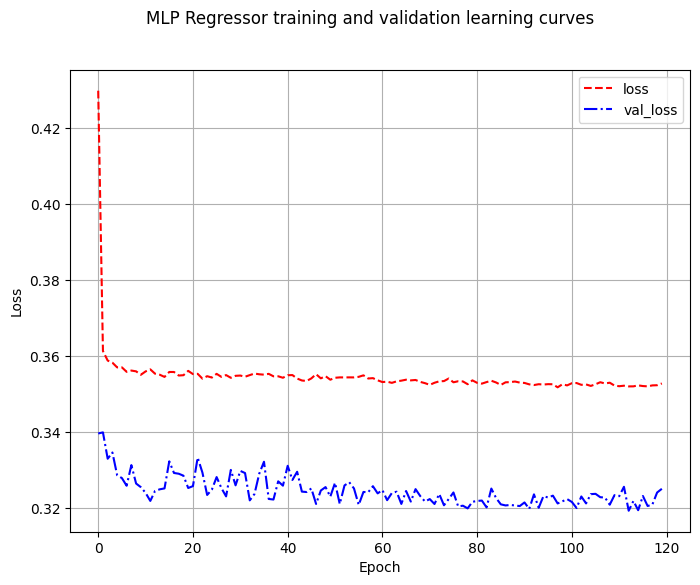

In [31]:
# Plot learning curves
fig = plot_learning_curves(history, title="MLP Regressor training and validation learning curves", figsize=(8, 6))

In [ ]:
# Load best model (after training)
best_model = load_mlp_model(checkpoint_path, y_scaler)

In [ ]:
# Save figure if required
save_fig("../models/mlp/mlp_loss_(4_32-16-8_lr25e-5)", fig=fig)

## 3. Model evaluation

In [ ]:
y_train_pred = make_predictions(best_model, X_train, y_scaler)
y_val_pred = make_predictions(best_model, X_val, y_scaler)
y_test_pred = make_predictions(best_model, X_test, y_scaler)

In [ ]:
# Calculate and display metrics for each split
train_mlp_metrics = calculate_metrics_by_class(y_train, y_train_pred, X_train[:, -1], "Training")
val_mlp_metrics = calculate_metrics_by_class(y_val, y_val_pred, X_val[:, -1], "Validation")
test_mlp_metrics = calculate_metrics_by_class(y_test, y_test_pred, X_test[:, -1], "Test")

In [ ]:
# Display predictded versus true vessel length plots for each split (use the rf regressor plot function)

# Prepare plot data dictionary - extract 'overall' metrics
plot_data = {
    'train_true': y_train, 'train_pred': y_train_pred,
    'val_true': y_val, 'val_pred': y_val_pred,
    'test_true': y_test, 'test_pred': y_test_pred,
    'train_metrics': train_mlp_metrics['overall'],
    'val_metrics': val_mlp_metrics['overall'],
    'test_metrics': test_mlp_metrics['overall'],
    'train_classes': X_train[:, -1],
    'val_classes': X_val[:, -1],
    'test_classes': X_test[:, -1]
}

# Generate all three plots side by side
plot_results(plot_data)